Global seed set to 0


(Running UniTVelo 0.2.5)
2023-10-18 11:14:30
0
0
0
0
0
1
0
0
2
0
0
3
0
1
0
0
1
1
0
1
2
0
1
3
0
2
0
0
2
1
0
2
2
0
2
3
1
0
0
1
0
1
1
0
2
1
0
3
1
1
0
1
1
1
1
1
2
1
1
3
1
2
0
1
2
1
1
2
2
Keeping at most 100000 cells per cluster
Filtered out 46616 genes that are detected 10 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...
Number of Leiden Clusters: 9
Maximal Number of Modules: 10


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]
Computing total RNAvelocity ...


  0%|          | 0/9815 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.5187637523748612, ('Blood progenitors 2', 'Erythroid1'): -0.409074538694137, ('Erythroid1', 'Erythroid2'): -0.7593683219818085, ('Erythroid2', 'Erythroid3'): -0.7397088218358892}
Total Mean: -0.6067288587216739
# In-cluster Coherence
{'Blood progenitors 1': 0.960294, 'Blood progenitors 2': 0.9743339, 'Erythroid1': 0.99154896, 'Erythroid2': 0.99018216, 'Erythroid3': 0.93013126}
Total Mean: 0.9692980647087097
1
2
3
Keeping at most 100000 cells per cluster
Filtered out 46616 genes that are detected 10 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of Leiden Clusters: 9
Maximal Number of Modules: 10
Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]
Computing total RNAvelocity ...


  0%|          | 0/9815 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.22534555196287787, ('Blood progenitors 2', 'Erythroid1'): -0.01913254227866085, ('Erythroid1', 'Erythroid2'): 0.05169335256750547, ('Erythroid2', 'Erythroid3'): -0.4848969979816638}
Total Mean: -0.16942043491392428
# In-cluster Coherence
{'Blood progenitors 1': 0.9881294, 'Blood progenitors 2': 0.9898233, 'Erythroid1': 0.98495746, 'Erythroid2': 0.9871974, 'Erythroid3': 0.98209924}
Total Mean: 0.9864413142204285


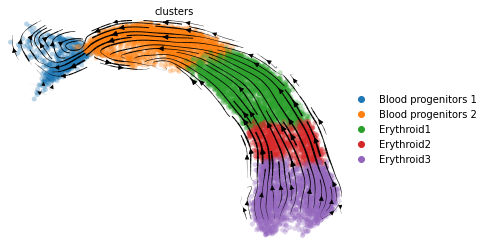

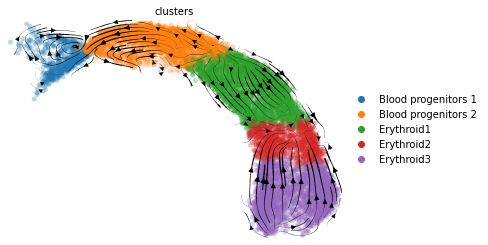

In [1]:
import scvelo as scv
import scanpy as sc
import cell2fate as c2f
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import torch
import unitvelo as utv
method = 'cell2fate'
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'
dataset = 'MouseErythroid'
n_genes_list = np.array((2000, 3000))
n_counts_list = np.array((20, 40, 10))
# Model params:
mod_list = [0.5, 1, 1.5, 2.0]
import torch

for i in range(len(n_genes_list)):
    for j in range(len(n_counts_list)):
        for k in range(len(mod_list)):
                print(i)
                print(j)
                print(k)
                n_genes = n_genes_list[i]
                min_counts = n_counts_list[j]
                model_index = str(i) + '-' + str(j) + '-' + str(k)
                save_name = method + '_' + dataset
                if exists(save_dir + save_name + '_CBDC_And_Posterior_withBatch5.csv'):
                    tab = pd.read_csv(save_dir + save_name + '_CBDC_And_Posterior_withBatch5.csv', index_col = 0)
                    if model_index in tab.index:
                        continue
                adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
                adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                                remove_clusters = [], min_shared_counts = min_counts, n_var_genes= n_genes)
                c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced',
                                                          batch_key = 'sequencing.batch')    
                n_modules = int(np.round(c2f.utils.get_max_modules(adata)*mod_list[k]))
                mod = c2f.Cell2fate_DynamicalModel(adata,
                                                   n_modules = n_modules, Tmax_prior={"mean": 500., "sd": 100.})   
                mod.train()
                sample_kwarg = {"num_samples": 3, "batch_size" : adata.n_obs,
                     "use_gpu" : True, 'return_samples': False}
                adata = mod.export_posterior(adata, sample_kwargs = sample_kwarg)
                mod.compute_and_plot_total_velocity_scvelo(adata, save = False, delete = False)
                # Calculate performance metrics:
                file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
                ground_truth = pickle.load(file)
                metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
                cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
                            for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
                if exists(save_dir + save_name + '_CBDC_And_Posterior_withBatch5.csv'):
                    tab = pd.read_csv(save_dir + save_name + '_CBDC_And_Posterior_withBatch5.csv', index_col = 0)
                else:
                    c_names = ['CBDC']
                    tab = pd.DataFrame(columns = c_names)
                tab.loc[model_index, 'CBDC'] = np.mean(cb_score)
                tab.loc[model_index, 'splicing_alpha'] = mod.samples['post_sample_means']['splicing_alpha']
                tab.loc[model_index, 'splicing_mean'] = mod.samples['post_sample_means']['splicing_mean']
                tab.loc[model_index, 'beta_g_mean'] = np.mean(mod.samples['post_sample_means']['beta_g'])
                tab.loc[model_index, 'beta_g_var'] = np.var(mod.samples['post_sample_means']['beta_g'])
                tab.loc[model_index, 'degredation_alpha'] = mod.samples['post_sample_means']['degredation_alpha']
                tab.loc[model_index, 'degredation_mean'] = mod.samples['post_sample_means']['degredation_mean']
                tab.loc[model_index, 'gamma_g_mean'] = np.mean(mod.samples['post_sample_means']['gamma_g'])
                tab.loc[model_index, 'gamma_g_var'] = np.var(mod.samples['post_sample_means']['gamma_g'])
                tab.loc[model_index, 'factor_level_g_mean'] = np.mean(mod.samples['post_sample_means']['factor_level_g'])
                tab.loc[model_index, 'factor_level_g_var'] = np.var(mod.samples['post_sample_means']['factor_level_g'])
                tab.loc[model_index, 'g_fg_mean'] = np.mean(mod.samples['post_sample_means']['g_fg'])
                tab.loc[model_index, 'g_fg_var'] = np.var(mod.samples['post_sample_means']['g_fg'])
                tab.loc[model_index, 'A_mgON_mean'] = np.mean(mod.samples['post_sample_means']['A_mgON'])
                tab.loc[model_index, 'A_mgON_var'] = np.var(mod.samples['post_sample_means']['A_mgON'])
                tab.loc[model_index, 'lam_mu'] = mod.samples['post_sample_means']['lam_mu']
                tab.loc[model_index, 'lam_sd'] = mod.samples['post_sample_means']['lam_sd']
                tab.loc[model_index, 'lam_m_mu_mean'] = np.mean(mod.samples['post_sample_means']['lam_m_mu'])
                tab.loc[model_index, 'lam_m_mu_var'] = np.var(mod.samples['post_sample_means']['lam_m_mu'])
                tab.loc[model_index, 'lam_mi_mean'] = np.mean(mod.samples['post_sample_means']['lam_mi'])
                tab.loc[model_index, 'lam_mi_var'] = np.var(mod.samples['post_sample_means']['lam_mi'])
                tab.loc[model_index, 'Tmax'] = mod.samples['post_sample_means']['Tmax']
                tab.loc[model_index, 't_c_loc'] = mod.samples['post_sample_means']['t_c_loc']
                tab.loc[model_index, 't_c_scale'] = mod.samples['post_sample_means']['t_c_scale']
                tab.loc[model_index, 'T_c_mean'] = np.mean(mod.samples['post_sample_means']['T_c'])
                tab.loc[model_index, 'T_c_var'] = np.var(mod.samples['post_sample_means']['T_c'])
                tab.loc[model_index, 't_delta_mean'] = np.mean(mod.samples['post_sample_means']['t_delta'])
                tab.loc[model_index, 't_delta_var'] = np.var(mod.samples['post_sample_means']['t_delta'])
                tab.loc[model_index, 'T_mON_mean'] = np.mean(mod.samples['post_sample_means']['T_mON'])
                tab.loc[model_index, 'T_mON_var'] = np.var(mod.samples['post_sample_means']['T_mON'])
                tab.loc[model_index, 'T_mON_mean'] = np.mean(mod.samples['post_sample_means']['T_mON'])
                tab.loc[model_index, 'T_mON_var'] = np.var(mod.samples['post_sample_means']['T_mON'])
                tab.loc[model_index, 'T_mOFF_mean'] = np.mean(mod.samples['post_sample_means']['T_mOFF'])
                tab.loc[model_index, 'T_mOFF_var'] = np.var(mod.samples['post_sample_means']['T_mOFF'])
                tab.loc[model_index, 'mu_expression_mean'] = np.mean(mod.samples['post_sample_means']['mu_expression'])
                tab.loc[model_index, 'mu_expression_var'] = np.var(mod.samples['post_sample_means']['mu_expression'])
                tab.loc[model_index, 'detection_mean_y_e_mean'] = np.mean(mod.samples['post_sample_means']['detection_mean_y_e'])
                tab.loc[model_index, 'detection_mean_y_e_var'] = np.var(mod.samples['post_sample_means']['detection_mean_y_e'])
                tab.loc[model_index, 'detection_hyp_prior_alpha'] = mod.samples['post_sample_means']['detection_hyp_prior_alpha']
                tab.loc[model_index, 'detection_y_c_mean'] = np.mean(mod.samples['post_sample_means']['detection_y_c'])
                tab.loc[model_index, 'detection_y_c_var'] = np.var(mod.samples['post_sample_means']['detection_y_c'])
                tab.loc[model_index, 'detection_y_i_mean'] = np.mean(mod.samples['post_sample_means']['detection_y_i'])
                tab.loc[model_index, 'detection_y_i_var'] = np.var(mod.samples['post_sample_means']['detection_y_i'])
                tab.loc[model_index, 'detection_y_gi_mean'] = np.mean(mod.samples['post_sample_means']['detection_y_gi'])
                tab.loc[model_index, 'detection_y_gi_var'] = np.var(mod.samples['post_sample_means']['detection_y_gi'])
                tab.loc[model_index, 's_g_gene_add_alpha_hyp_mean'] = np.mean(mod.samples['post_sample_means']['s_g_gene_add_alpha_hyp'])
                tab.loc[model_index, 's_g_gene_add_alpha_hyp_var'] = np.var(mod.samples['post_sample_means']['s_g_gene_add_alpha_hyp'])
                tab.loc[model_index, 's_g_gene_add_mean_mean'] = np.mean(mod.samples['post_sample_means']['s_g_gene_add_mean'])
                tab.loc[model_index, 's_g_gene_add_mean_var'] = np.var(mod.samples['post_sample_means']['s_g_gene_add_mean'])
                tab.loc[model_index, 's_g_gene_add_alpha_e_inv_mean'] = np.mean(mod.samples['post_sample_means']['s_g_gene_add_alpha_e_inv'])
                tab.loc[model_index, 's_g_gene_add_alpha_e_inv_var'] = np.var(mod.samples['post_sample_means']['s_g_gene_add_alpha_e_inv'])
                tab.loc[model_index, 's_g_gene_add_mean'] = np.mean(mod.samples['post_sample_means']['s_g_gene_add'])
                tab.loc[model_index, 's_g_gene_add_var'] = np.var(mod.samples['post_sample_means']['s_g_gene_add'])
                tab.loc[model_index, 'stochastic_v_ag_hyp_mean'] = np.mean(mod.samples['post_sample_means']['stochastic_v_ag_hyp'])
                tab.loc[model_index, 'stochastic_v_ag_hyp_var'] = np.var(mod.samples['post_sample_means']['stochastic_v_ag_hyp'])
                tab.loc[model_index, 'stochastic_v_ag_inv_mean'] = np.mean(mod.samples['post_sample_means']['stochastic_v_ag_inv'])
                tab.loc[model_index, 'stochastic_v_ag_inv_var'] = np.var(mod.samples['post_sample_means']['stochastic_v_ag_inv'])
                tab.to_csv(save_dir + save_name + '_CBDC_And_Posterior_withBatch5.csv')